In [1]:
from pandas import Series, DataFrame
import pandas as pd
import calendar
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Setup

In [2]:
#read data in, appended 2014/2015, removed GO from col names
crime2014 = pd.read_csv("Austin_Crime_2014.csv", dtype=unicode, encoding='utf-8')
crime2014[:3]

crime2015 = pd.read_csv("Austin_Crime_2015.csv", dtype=unicode, encoding='utf-8')
crime = crime2014.append(crime2015,ignore_index=True)

crime = crime.rename(index=str, columns={"Highest NIBRS/UCR Offense Description": "General Offense Description",\
                                 "GO Highest Offense Desc":"Detailed Offense Description",\
                                 "GO Location":"Location","GO Report Date":"Report Date",\
                                 "GO Location Zip":"Zipcode","GO District":"District","GO Census Tract":"Census Tract",\
                                 "GO X Coordinate":"X Coordinate","GO Y Coordinate":"Y Coordinate",\
                                      "GO Primary Key":"Primary Key"})

crime = crime.drop('Location_1', axis=1)
crime['Date'] = pd.DatetimeIndex(crime['Report Date'])
crime['Month'] = pd.DatetimeIndex(crime['Date']).month
crime['Month'] = crime['Month'].apply(lambda x: calendar.month_abbr[x])
crime['Year'] = pd.DatetimeIndex(crime['Report Date']).year

crime.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Detailed Offense Description,Location,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,General Offense Description,Date,Month,Year
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,12151 N IH 35 SVRD NB ...,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Apr,2014
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,3300 BLOCK ROCKHURST LN ...,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Apr,2014
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,E 7TH ST / CHICON ST ...,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,May,2014
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,WHELESS LN / BERKMAN DR ...,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Jun,2014
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,WALLER ST / E 2ND ST ...,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Jul,2014


## Merge Crimes

In [7]:
def merge_crimes(s):
    """Map some crimes together."""
    
    # Create a map of misspellings to correct spelling
    misspellings = {'Burglary / \nBreaking & Entering':'Burglary',
                    'Auto Theft':'Theft: Auto Parts',
                    'Homicide: Murder & Nonnegligent Manslaughter':'Murder',
                    'Agg Assault':'Aggravated Assault'}
    
    if s in misspellings:
        return misspellings[s]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_crimes)

def merge_theft(s):
    """Map some crimes together."""
    
    if (s[:5]=='Theft'):
        return s[:5]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_theft)

# Check that it worked
# mask = (crime['General Offense Description'] == 'Agg Assault')
# crime['General Offense Description'][mask]  # should be empty

crime['General Offense Description'].value_counts()

Theft                 61908
Burglary              10597
Aggravated Assault     3803
Robbery                1809
Rape                   1042
Murder                   55
Name: General Offense Description, dtype: int64

# Final Dataframe

In [8]:
crime.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Detailed Offense Description,Location,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,General Offense Description,Date,Month,Year
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,12151 N IH 35 SVRD NB ...,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Apr,2014
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,3300 BLOCK ROCKHURST LN ...,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Apr,2014
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,E 7TH ST / CHICON ST ...,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,May,2014
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,WHELESS LN / BERKMAN DR ...,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Jun,2014
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,WALLER ST / E 2ND ST ...,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Jul,2014


## Example Stacked Graph

Total crime count: 8491


Theft                 7243
Burglary               598
Aggravated Assault     300
Robbery                206
Rape                   141
Murder                   3
Name: General Offense Description, dtype: int64


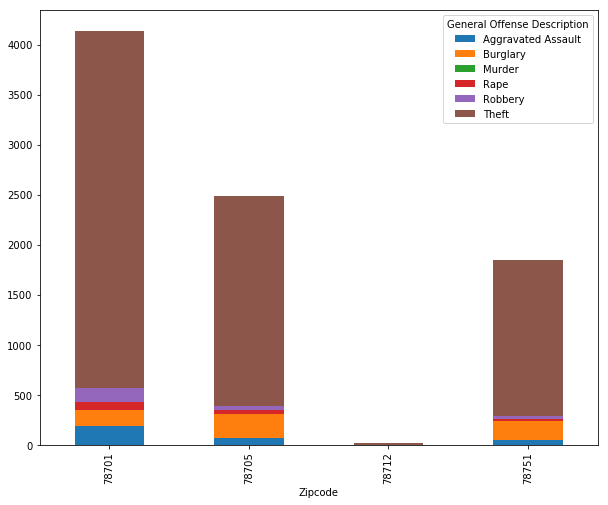

In [9]:
crime_wc = crime['Zipcode']=="78705"
crime_ut = crime['Zipcode']=="78712"
crime_hyde = crime['Zipcode']=="78751"
crime_dt = crime['Zipcode']=="78701"
area_mask = crime_wc | crime_ut | crime_hyde | crime_dt

#print(area_mask)

crime_student = crime[area_mask]

pylab.rcParams['figure.figsize'] = (10, 8)

test5 = crime_student.groupby(['Zipcode', 'General Offense Description'])['Zipcode'].count().unstack('General Offense Description').fillna(0)
test5.plot(kind='bar', stacked=True)


# total crime count
print "Total crime count:", crime_student['General Offense Description'].count()

# crime split into offenses
crime_student_vc = crime_student['General Offense Description'].value_counts()
print "\n"
print(crime_student_vc)
#crime_student_vc.plot(kind='bar')


Total crime count: 8491


Theft                 7243
Burglary               598
Aggravated Assault     300
Robbery                206
Rape                   141
Murder                   3
Name: General Offense Description, dtype: int64


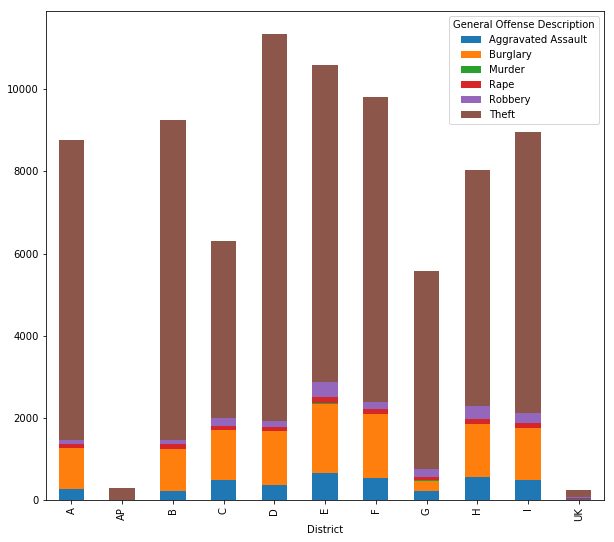

In [11]:
pylab.rcParams['figure.figsize'] = (10, 9)

crime_district = crime.groupby(['District', 'General Offense Description'])['District'].count().unstack('General Offense Description').fillna(0)
crime_district.plot(kind='bar', stacked=True)


# total crime count
print "Total crime count:", crime_student['General Offense Description'].count()

# crime split into offenses
crime_student_vc = crime_student['General Offense Description'].value_counts()
print "\n"
print(crime_student_vc)
#crime_student_vc.plot(kind='bar')
